In [39]:
import os
import json
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData

path = r"C:\Users\MainUser\project\cs224w_cb_graph\info_folder\score.json"
records = []

with open(path, "r", encoding="utf-8") as f:
    data = json.load(f)

    for entry in data:

        speech_id  = entry["id"]
        tone_score = entry['gpt-5']

        for topic, score in tone_score.items():
            records.append({
                "speech_id": speech_id,
                "topic": topic,
                "tone_score": score
            })

df = pd.DataFrame(records)
df["tone_norm"] = df.groupby("topic")["tone_score"].transform(
    lambda x: (x - x.mean()) / x.std()
)
df.head()

,speech_id,topic,tone_score,tone_norm
0,feddsp:95906,Fed Funds Rate,0.0,-0.201565
1,feddsp:95906,Labor Market,0.0,-0.387294
2,feddsp:95906,Inflation,0.0,-0.525486
3,feddsp:95906,Real Activity,0.0,-0.351968
4,feddsp:95906,Financial Stability,-0.5,-2.117084


In [40]:
speech_texts = {}
text_data_folder = r"C:\Users\MainUser\project\cs224w_cb_graph\text_data"
speakers = []

for filename in os.listdir(text_data_folder):
    if not filename.endswith(".json"):
        continue
    path = os.path.join(text_data_folder, filename)
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for entry in data:
        speech_id = entry["id"]
        speech_texts[speech_id] = entry.get("text", "")
        speakers += [entry["author"]]
speakers = list(set(speakers))

In [41]:
embedder   = SentenceTransformer("all-MiniLM-L6-v2")
speech_ids = list(speech_texts.keys())
speech_embeddings = (
    embedder.encode([speech_texts[i] for i in speech_ids], normalize_embeddings=True))

unique_topics = sorted(df["topic"].unique())
topic_embeddings = embedder.encode(unique_topics, normalize_embeddings=True)

speakers_embeddings = embedder.encode(speakers, normalize_embeddings=True)

print(f"\nGenerated \n"
      f"{len(speech_embeddings)} speech embeddings \n"
      f"{len(speakers_embeddings)} speaker embeddings \n"
      f"{len(topic_embeddings)} topic embeddings.")


Generated 
55 speech embeddings 
2 speaker embeddings 
6 topic embeddings.


In [42]:
data = HeteroData()

data["speech"].x = torch.tensor(speech_embeddings, dtype=torch.float)
data["topic"].x = torch.tensor(topic_embeddings, dtype=torch.float)
data["speaker"].x = torch.tensor(speakers_embeddings, dtype=torch.float)

speech_to_idx = {sid: i for i, sid in enumerate(speech_ids)}
topic_to_idx = {t: i for i, t in enumerate(unique_topics)}
speaker_to_idx = {s: i for i, s in enumerate(speakers)}

edge_index = []
edge_attr = []

for _, row in df.iterrows():
    s_idx = speech_to_idx[row["speech_id"]]
    t_idx = topic_to_idx[row["topic"]]
    edge_index.append([s_idx, t_idx])
    edge_attr.append([row["tone_norm"]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

data["speech", "discusses", "topic"].edge_index = edge_index
data["speech", "discusses", "topic"].edge_attr = edge_attr

print(f"\nGraph summary:")
print(data)
print(f"Speech–Topic edges: {edge_index.shape[1]}")

result_folder = r"C:\Users\MainUser\project\cs224w_cb_graph\info_folder"
torch.save(data, os.path.join(result_folder, "fed_speech_graph.pt"))




Graph summary:
HeteroData(
  speech={ x=[55, 384] },
  topic={ x=[6, 384] },
  speaker={ x=[2, 384] },
  (speech, discusses, topic)={
    edge_index=[2, 306],
    edge_attr=[306, 1],
  }
)
Speech–Topic edges: 306


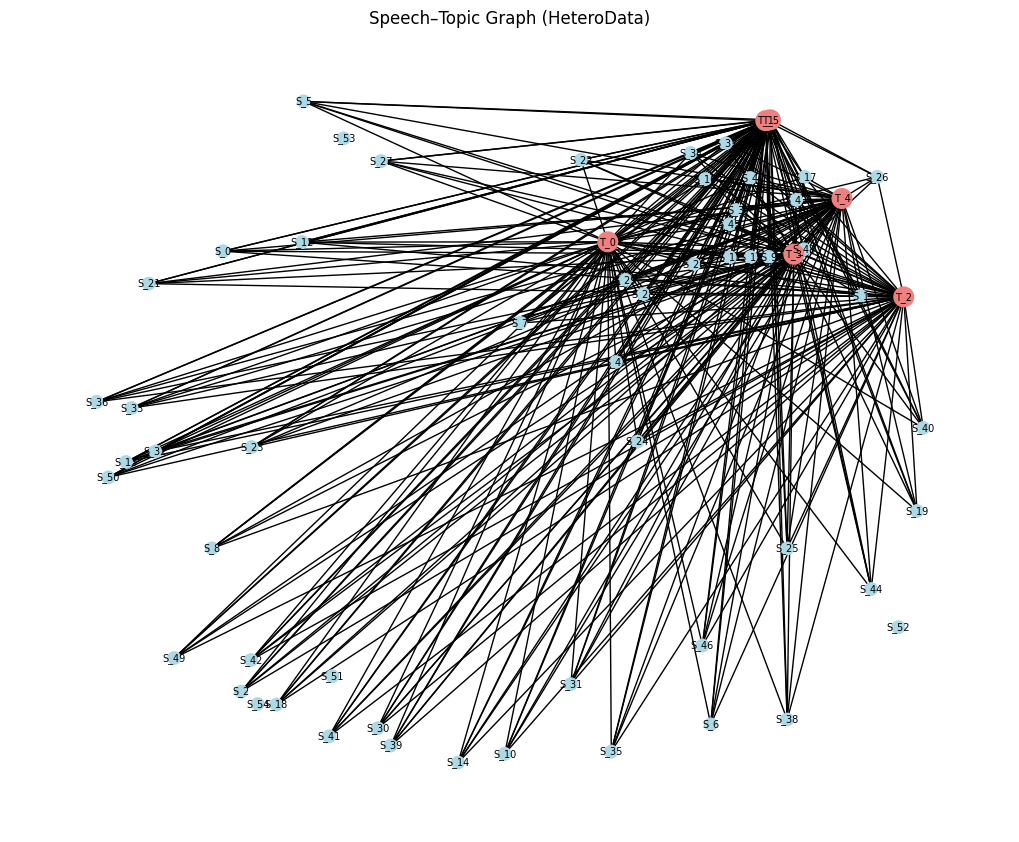

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

edge_index = data['speech', 'discusses', 'topic'].edge_index
edge_attr = data['speech', 'discusses', 'topic'].edge_attr

G = nx.Graph()

for i in range(data['speech'].num_nodes):
    G.add_node(f"S_{i}", type='speech')
for j in range(data['topic'].num_nodes):
    G.add_node(f"T_{j}", type='topic')

for k in range(edge_index.shape[1]):
    s = edge_index[0, k].item()
    t = edge_index[1, k].item()
    weight = edge_attr[k].item()
    G.add_edge(f"S_{s}", f"T_{t}", weight=weight)

colors = ['lightblue' if n.startswith('S') else 'lightcoral' for n in G.nodes()]
sizes = [80 if n.startswith('S') else 200 for n in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.5)
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=sizes, font_size=7)
plt.title("Speech–Topic Graph (HeteroData)")
plt.show()
